# Metrics of 2013 – 2019 Main Crawls


In December 2019 the Common Crawl's [columnar index](https://commoncrawl.org/2018/03/index-to-warc-files-and-urls-in-columnar-format/) has been extended to include all WARC files released since 2013. Some metrics about the 65 monthly crawls are calculated to verify the index. [AWS Athena](https://aws.amazon.com/athena/) is used for the SQL aggregations. All Athena results are kept in the folder [data/](./data/) from where they are read for visualization and further processing.

### Count Page Captures per Monthly Crawl and Subset

```sql
SELECT COUNT(*) as n_captures,
       crawl,
       subset
FROM "ccindex"."ccindex"
GROUP BY crawl, subset
ORDER BY crawl, subset ASC;
```

In [1]:
%matplotlib notebook
import pandas as pd

df = pd.read_csv('data/cc-main-2013-2019-data-set-counts.csv')
df['n_captures'].sum()/10**9

197.994100154

Almost 200 billion page captures. That's a lot, but this number includes redirects, 404s and robots.txt captures. To get the number of successful fetches only, we need to sum up by subset. The subset "warc" includes only successful fetches. The ["robotstxt" and "crawldiagnostics" subsets](https://commoncrawl.org/2016/09/robotstxt-and-404-redirect-data-sets/) have been introduced in 2016 and contain robots.txt files resp. captures with HTTP response status codes other than 200.

In [2]:
df.groupby(['subset']).sum()

,n_captures
subset,
crawldiagnostics,25629950925
robotstxt,4803256615
warc,167560892614


### Unique URLs by Top-Level Domain

To get approximate numbers of unique URLs by top-level domain in a reasonable speed we use [Presto's HyperLogLog functions](https://prestodb.io/docs/current/functions/hyperloglog.html), here for the `.edu` TLD. We also count the number of unique hosts and domains, and also the total number of page captures:

```sql
SELECT crawl,
       COUNT(*) AS n_captures,
       cardinality(approx_set(url)) AS uniq_urls_estim,
       COUNT(DISTINCT url_host_name) AS uniq_hosts,
       COUNT(DISTINCT url_host_registered_domain) AS uniq_domains,
       to_base64(CAST(approx_set(url) AS varbinary)) AS uniq_urls_hll
FROM "ccindex"."ccindex"
WHERE subset = 'warc'
  AND url_host_tld = 'edu'
GROUP BY crawl
ORDER BY crawl ASC;
```

In [3]:
df = pd.read_csv('data/cc-main-2013-2019-edu-tld-uniq-urls-hll.csv')
df['n_captures'].sum()/10**9

2.834692397

There are 2.8 billion pages captures only from sites in the `.edu` top-level domain. How are they distributed over time?

<IPython.core.display.Javascript object>


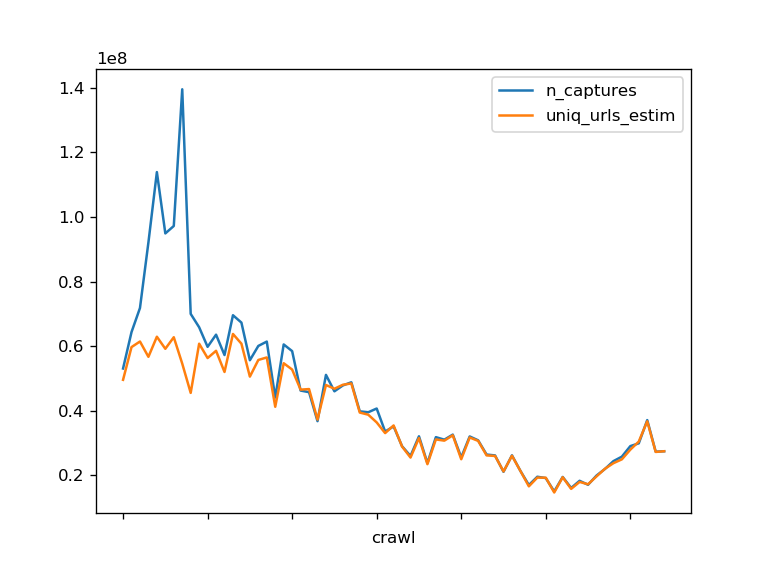

In [4]:
df.plot.line(x='crawl', y=['n_captures', 'uniq_urls_estim'])

Two things are immediately visible in the plot: first, there is a significant amount of duplicate captures of the same URL during the first years. Second, over time the number of unique URLs per month from the `.edu` TLD has decreased. In recent crawls the trend has been inverted and the number of `.edu` pages is now growing.

#### Merging HyperLogLogs and Aggregation by Year

Monthly crawls overlap only partially and recently the crawls have been improved to achieve a better coverage in the breadth when multiple monthly crawls are combined. To measure the coverage we aggregate by year. We could just replace `crawl` by `substr(crawl, 9, 4)` in the last SQL query. However, because the HyperLogLog sketches are stored in the result we could do it in a smarter way:
1. import the [result of the previous query](./data/cc-main-2013-2019-uniq-urls-hll.csv) into Athena as a new table
2. aggregate by year using the monthly HyperLogLog sketches

We start with the table import:
```sql
-- import Athena result file using OpenCSVSerde
--  see https://docs.aws.amazon.com/athena/latest/ug/csv.html
-- NOTE:
--- * need to remove the header line (does not fit into the schema)
--- * place the CSV result file into an empty folder on S3 
CREATE EXTERNAL TABLE IF NOT EXISTS ccindex.hll20132019 (
  `crawl` string,
  `n_captures` bigint,
  `uniq_urls_estim` bigint,
  `uniq_hosts` bigint,
  `uniq_domains` bigint,
  `uniq_urls_hll` string 
)
ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
WITH SERDEPROPERTIES (
   'separatorChar' = ',',
   'quoteChar'     = '"',
   'escapeChar'    = '"'
)
LOCATION 's3://my-bucket/uniq-urls-hll/'
TBLPROPERTIES ('has_encrypted_data'='false');
```

Then we run the aggregation by year:
```sql
SELECT substr(crawl, 9, 4) AS year,
       COUNT(*) AS n_crawls,
       SUM(n_captures) AS n_captures,
       cardinality(merge(cast(from_base64(uniq_urls_hll) AS HyperLogLog))) AS uniq_urls_estim
FROM ccindex.hll20132019
GROUP BY substr(crawl, 9, 4)
ORDER BY substr(crawl, 9, 4) ASC;
```

<IPython.core.display.Javascript object>


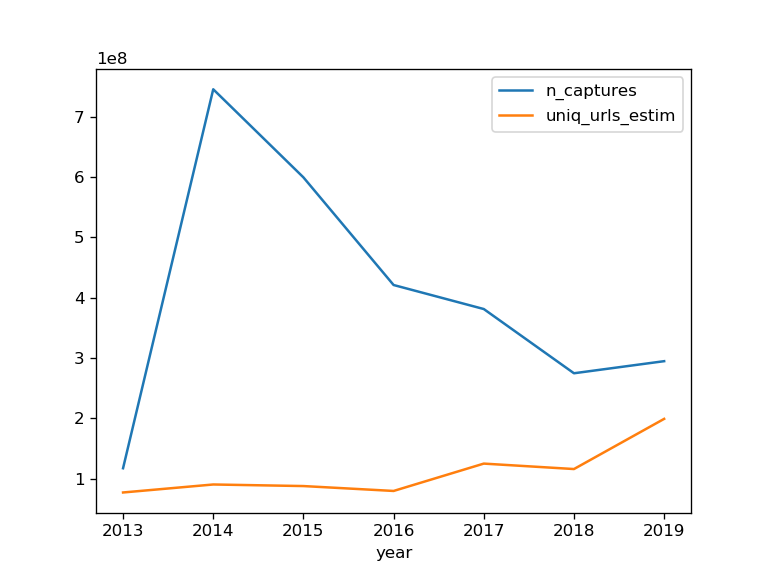

In [5]:
df = pd.read_csv('data/cc-main-2013-2019-edu-tld-uniq-urls-hll-by-year-merged.csv')
df.plot.line(x='year', y=['n_captures', 'uniq_urls_estim'])

In [6]:
df['ratio'] = df['uniq_urls_estim']/df['n_captures']
df

,year,n_crawls,n_captures,uniq_urls_estim,ratio
0,2013,2,117484962,77307027,0.658016
1,2014,8,745488582,90549574,0.121463
2,2015,10,599500761,87944690,0.146697
3,2016,9,421122505,79832061,0.189570
4,2017,12,381319425,125164575,0.328241
5,2018,12,274875118,116145047,0.422538
6,2019,12,294901044,199290447,0.675788


The number of unique URLs contained in all data sets of a single year has increased and reached almost 200 million in 2019.

But how is the aggregated coverage for sites?  We could add also HyperLogLog sketches for hosts and domains but for simplicity we modify the previous query and run it on the entire table:
```sql
SELECT substr(crawl, 9, 4) as year,
       COUNT(*) AS n_captures,
       cardinality(approx_set(url)) AS uniq_urls_estim,
       COUNT(DISTINCT url_host_name) AS uniq_hosts,
       COUNT(DISTINCT url_host_registered_domain) AS uniq_domains
FROM "ccindex"."ccindex"
WHERE subset = 'warc'
  AND url_host_tld = 'edu'
GROUP BY substr(crawl, 9, 4)
ORDER BY substr(crawl, 9, 4) ASC;
```

In [7]:
df = pd.read_csv('data/cc-main-2013-2019-edu-tld-uniq-urls-hll-by-year.csv')
df

,year,n_captures,uniq_urls_estim,uniq_hosts,uniq_domains
0,2013,117484962,77307027,149924,5962
1,2014,745488582,90549574,164248,6046
2,2015,599500761,87944690,158094,5985
3,2016,421122505,79832061,181581,6245
4,2017,381319425,125164575,232770,6322
5,2018,274875118,116145047,232067,6310
6,2019,294901044,199290447,215421,6070


The HyperLogLog cardinality estimates for the URLs give the same number, so we can be sure that the (de)serialization works.

Regarding the number of hosts and domains covered per year: the number of hosts has increased over time while the number of domains has always been around 6,000.